# Training: An exercise in futility?

Regular trainings in organizations tend to be a common aspect of corporate life and are arguably necessary for the ongoing growth of the employees as well as the company as a whole. Though the actual impact of these are difficult to measure. In theory, these trainings should result in new skills, updates on new trends in a given field, increased expsoure to the business for employees outside of operations and even networking/collaboration opportunities. 

All of these should, in theory, positively impact an individual's performance rating. I'm going to test this, using a dataset from kaggle called "HR Employee Dataset", see below for the link. 



In [4]:
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as py
#https://www.kaggle.com/datasets/jash312/hr-employee-attrition-datasets?resource=download&select=HR+Employee+data.csv
df = pd.read_csv(r"C:\Users\Ian\Desktop\HR Employee data.csv")

In [5]:
df.columns

Index(['EmployeeID', 'JoiningYear', 'Age', 'BusinessTravel', 'DailyRate',
       'Department', 'DistanceFromHome', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition', 'LeavingYear', 'Reason', 'RelievingStatus', 'office_code',
       'JobLevel_updated'],
      dtype='object')


## First Look

I'm starting off by looking through the columns, as I already know there are several I don't need and I'd like to keep the notebook organized. From what I saw of the file on Kaggle, there were quite a few, many of which could be interesting to include in the analysis. However, to avoid the rabbit hole of scope creep and for the purposes of this analysis, I'll stick with a few basic ones: 
1. EmployeeID - This could be useful to have as a unique value. 
2. PerformanceRating - Of course I'll need this one
3. TrainingTimesLastYear - This and #2 form the foundation of the analysis 
4. Joblevel_updated - This may be useful, I may want to segment by job level. It's fair to assume that even though there's a universal rating scale across the company, an executive would not be evaluated on the same criteria as an entry-level employee. 
    

In [7]:
df = pd.concat([df["EmployeeID"], df["PerformanceRating"],df["TrainingTimesLastYear"], df["JobLevel_updated"]], axis = 1)
df.describe()

,EmployeeID,PerformanceRating,TrainingTimesLastYear
count,13423.000000,13423.000000,13423.000000
mean,106711.000000,3.108247,2.454518
std,3875.030667,0.667023,1.069622
min,100000.000000,1.000000,0.000000
25%,103355.500000,3.000000,2.000000
50%,106711.000000,3.000000,2.000000
75%,110066.500000,3.000000,3.000000
max,113422.000000,5.000000,6.000000


Based on the above, there are a few things that stand out:
1. It looks like the vast majority of employees have a performance rating of 3 out of 5. In my experience, this heavy centrality is common in large companies, which you'd expect to a certain extent, but we can see there's very little deviation from that, to the extent that you could almost consider ratings of 1, 2, 4, and 5 to be outliers. I'm going to start by looking at the distribution of this variable to see if there's anything I can do to make it more test-friendly.
2. It also looks like the majoirty of employees have had some type of training. We don't know what kind or the quality of it, but for the purposes of this analysis, I'll assume its job-relevant. 


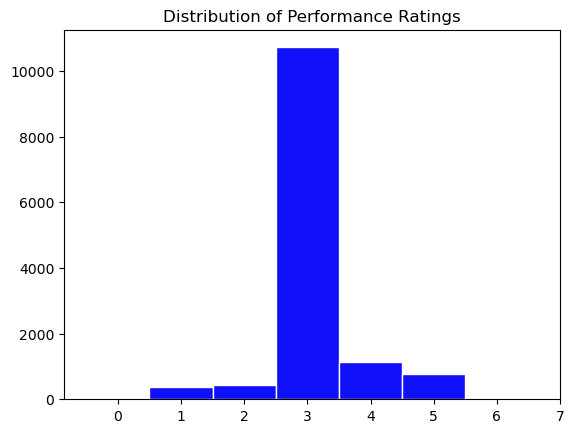

In [25]:
bins = np.arange(8) - 0.5
py.hist(df["PerformanceRating"], bins, color = "#0F0FF9", edgecolor = "white")
py.title("Distribution of Performance Ratings")
py.xticks(range(8))

py.show()

In [10]:
def nor(var): #Using a custom fuction to be able to retest normality after the transformation 
    test = stats.normaltest(var)
    if (test.pvalue<=.05):
        print(" p-value =", test.pvalue, "\n","This is a non-normal distribution")
    else:
        print("p-value =", test.pvalue, "\n", " .01, this is a normal distribution" )

Unfortunately, this looks like a textbook example of a leptokurtic distribution. Just to be thorough, I'll test for normality. I can try to apply a transformation as well, but with this level of excess kurtosis, the disribution is unlikely to be very malleable. 


 p-value = 0.0 
 This is a non-normal distribution


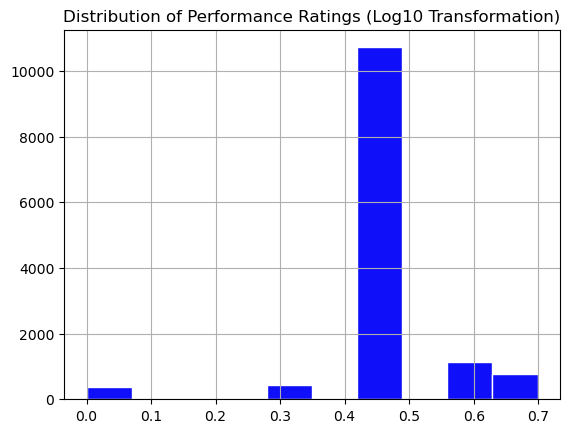

In [24]:
np.log10(df["PerformanceRating"]).hist(color = "#0F0FF9", edgecolor = "white") #Creating the histogram for a visual look at the distibution
py.title("Distribution of Performance Ratings (Log10 Transformation)"), 


nor(np.log10(df["PerformanceRating"])) # Log base 10 transformation, test for normality 

Even with the log10 transformation, this is an unfortunate distribution, analytically speaking and in terms of the actual performance appraisals. 
While you would expect to see the majority of employees in the center, the fact that such a small proportion is above or below that suggests a couple factors might be at play here:
1. There are unclear evaluation guidelines. Managers are unsure how they can distinguish between an employee who "Meets Expectations" vs. ones who are "Above Expectations", for example. So, to avoid issues, the managers may be "playing it safe" and rating employees in the middle. 
2. Managers may have the correct guidence on how to distinguish but not know how to implement it. In other words, they may not feel comfortable explaining to their employees why they might be at a 1 or 2, so instead they just put them at a 3. 
3. Finally, it could be that performance appraisals are not taken too seriously at this company, that leaders just enter a middle-ground rating to satisfy the requirements of their roles, without much thought. 

Given that this set of ratings is effectively all 3s with some outliers, my next best bet is probably stratification. 
Even though there's a common rating scale, there should be different levels of proficiency for each level of seniorty. e.g., Directors are likely evaluated against different standards than entry-level analysts, for example. I'll use the job level variable to see if I can get a more test-friendly sample. 


## A different approach

In [14]:
pd.DataFrame(df["PerformanceRating"].groupby(df["JobLevel_updated"]).value_counts())

count
JobLevel_updated PerformanceRating       
L1               3                   4298
                 4                    614
                 5                    499
                 2                    285
                 1                    237
L2               3                   3791
                 4                    310
                 5                    160
                 1                     88
                 2                     83
L3               3                   1338
                 4                    136
                 5                     80
                 1                     49
                 2                     46
L4               3                    711
                 4                     37
                 2                      7
                 5                      7
L5               3                    428
                 4                     15
                 5                      2
                 2                      2
                 1                      2
L6               3                    146
                 4                     17
                 5                     11
                 2                     10
                 1                      6
L7               3                      5
                 4                      3


It looks like L1 employees represent a large chunk of the employee population, so I'll continue the analysis focusing on just L1 employees which should at least minimize the leptokurtosis . 


In [27]:
new_df = df[(df["JobLevel_updated"] == "L1")]
new_df.describe()

,EmployeeID,PerformanceRating,TrainingTimesLastYear
count,5933.000000,5933.000000,5933.000000
mean,108169.445980,3.143772,2.450868
std,3577.835606,0.791940,1.066953
min,100208.000000,1.000000,0.000000
25%,105248.000000,3.000000,2.000000
50%,108624.000000,3.000000,2.000000
75%,111372.000000,3.000000,3.000000
max,113420.000000,5.000000,6.000000


(Text(0.5, 1.0, 'Distribution of Performance Ratings\n(L1 Employees Only)'),)

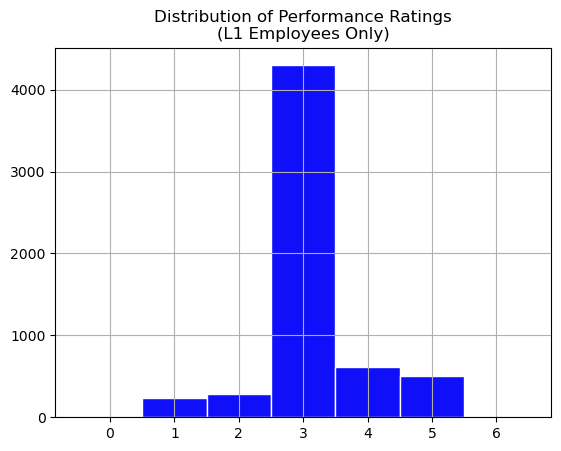

In [26]:
pr = new_df["PerformanceRating"] #Creating a variable for this so that it's easier to call 

pr.hist(bins = bins, color = "#0F0FF9", edgecolor = "white")
py.title("Distribution of Performance Ratings"+"\n"+"(L1 Employees Only)"), 

This is still a non-normal distibution. I'll need to use a non-parametic test to see if there are any significant group differences, the Mann–Whitney U test should do the trick as these are independent groups. 



In [28]:
pd.DataFrame(new_df["PerformanceRating"].groupby(new_df["TrainingTimesLastYear"]).mean()) # Grouping but the number of training sessions attended. 

,PerformanceRating
TrainingTimesLastYear,
0,3.240664
1,3.141860
2,3.150836
3,3.109951
4,3.169091
5,3.137339
6,3.150000


If trainings did impact ratings, I would expect to see an increase in average ratings as the number of trainings increase. But at first glance, the ratings across all training groups is very close. Interestingly, those with zero trainings have the highest average performance rating, though not by much. At this point, I can probably say that this analysis is inconclusive at best. But just to be thorough, I'd like to test the significance of the "0 Trainings" group against the others. I will, of course, be taking the results with a (massive) grain of salt knowing how large the sample is.  


## Non-Parametric Testing

In [19]:
for i in range(0, 7):
    x = (i+1)
    if ((i+1)<= 6): # The If-statment here creates a variable I can use as an iterative training group number against 0. 

        a = new_df[(new_df["TrainingTimesLastYear"] == 0)]["PerformanceRating"] # Creating test variables
        b = df[(df["TrainingTimesLastYear"] == (x))]["PerformanceRating"]
        
        p = stats.mannwhitneyu(a, b).pvalue.round(3) # Simplifying and rounding test statistics 
        tstat = stats.mannwhitneyu(a, b).statistic.round(3)
        
        
        print("Ratings for Employees with 0 Trainings n =241 vs Employees with", (x), "Training(s) n=",b.value_counts().sum(),"", "\n", "Test Statistic:", tstat,"p-value:", p, "\n")



Ratings for Employees with 0 Trainings n =241 vs Employees with 1 Training(s) n= 1116  
 Test Statistic: 147150.0 p-value: 0.002 

Ratings for Employees with 0 Trainings n =241 vs Employees with 2 Training(s) n= 6370  
 Test Statistic: 828352.0 p-value: 0.004 

Ratings for Employees with 0 Trainings n =241 vs Employees with 3 Training(s) n= 3602  
 Test Statistic: 476104.0 p-value: 0.0 

Ratings for Employees with 0 Trainings n =241 vs Employees with 4 Training(s) n= 1208  
 Test Statistic: 158377.0 p-value: 0.002 

Ratings for Employees with 0 Trainings n =241 vs Employees with 5 Training(s) n= 567  
 Test Statistic: 74218.5 p-value: 0.005 

Ratings for Employees with 0 Trainings n =241 vs Employees with 6 Training(s) n= 103  
 Test Statistic: 13343.5 p-value: 0.158 




Considering the sample size here, I'm not suprised that most of these came out with p<.01. In fact, the only one that was not significant was 0 vs 6, in which the latter had a sample size of 103. If I wanted to account for the differences in sample sizes, I would likely take equal sized random samples from the different groups and run the test severval hundred times (using a loop, of course) to see how frequently I would get significant results. I don't think the juice would be worth the squeeze though. In fact, running the above tests was unnecessary. Even if I could get reliable significance, all it does is confirm the ~.1 difference in ratings across groups. 

What may be happening here is the "0 Trainings" group is acting as a proxy indicator for newly hired. In other words, these could be new employees who have taken 0 trainings last year because they were not employed by the organization last year. 
If so, their slightly-higher-than-average performance ratings could be attributed to a "honeymoon period", in which they may be new to role and motivated enough that they exceeded leader expectations for new hires. 

To wrap up, my main take-aways are as follows: 
1. Considering the data, the performance appraisal process at this company appears to have a bias towards neutral ratings.Based on my own experience executing performance management processes at large organizations this could be due to a number of reasons. What resources are available to leaders to help them with the process? What is the culture around performance management? How and when is this communicated to leaders? What direction are they given prior to starting the process?
2. There is no conclusive link between performance ratings and training sessions attended. This could be a result of the point above, or it could reflect ineffective/irrelevent trainings. 
3. A more useful analysis might consider looking at trainings and more quantifiable performance metrics from a specific functional group. For example, employees in the sales department and individualized annual sales, or Support Desk/IT and support tickets resolved. 
